# Powershell Obfuscation Support Vector Classifier

Supervised learning classifier, that attempts to classify Powershell commands as obfuscated|non-obfuscated based
on counts of various characters.

Prework: 
This notebook will ingest a CSV file of Powershell commands, with all commandline arguments.
This can be obtained from EID 1 (Sysmon) or 800.
Specifically, look for Powershell commands run by a user (not an automated process), and did NOT run from a .ps1 script
(meaning it ran direct from shell, which is more consistent with adversary activity).  This should consist of benign, non-obfuscated commands.  Concatenate and de-duplicate this list.  The column name should be "commandline".  This will be the basis for our training set.

Pseudo-search logic:
    eventid:(800|1) userID:<yourIDformat> NOT commandline:*.ps1*
    
Next: Create a list of obfuscated Powershell commands.  You can collect these from public sources, or generate your own with a tool like Invoke-Obfuscation (https://github.com/danielbohannon/Invoke-Obfuscation).  Append this list to your existing list of (benign) Powershell commands.
    
Finally: append a new column called "isobfuscated" that takes a value of 1 for "obfuscated" and 0 for "not obfuscated".  The entries from the first (benign) list should all be 0, and the obfuscated list should all be 1.  
    
This finalized list will be ingested as our testing/training dataset.  We will use sklearn's fit() function for training, and the predict() function for testing. 

In [ ]:
# Import things.

import plotly
import plotly.express as px
from plotly.offline import plot
import pandas as pd
import sys
import numpy as np
import os
from sklearn.svm import SVC
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
pd.options.display.html.use_mathjax = False

# Part I: Training and Testing

In [ ]:
# Ingest the training dataset you built above.

file = input("Enter the location of a CSV file:")
df = pd.read_csv(file, encoding="ANSI", header=0)

# Strip off any leading/trailing whitespace
df['commandline'] = df['commandline'].str.strip()

# Create a "length" column, containing the string length of each command
df['length'] = df['commandline'].str.len()

df = df.dropna(axis=0)
print('Ingested ' + str(df.shape[0]) + ' lines of data')

In [ ]:
# The meat of the story: get a count of various characters, to use as features of our classifier.
# This will form the basis for our training dataset.
df['semicoloncount'] = df['commandline'].str.count('\;')
df['doublequotecount'] = df['commandline'].str.count('\"')
df['singlequotecount'] = df['commandline'].str.count('\'')
df['backtickcount'] = df['commandline'].str.count('\`')
df['plussigncount'] = df['commandline'].str.count('\+')
df['leftbracecount'] = df['commandline'].str.count('\{')
df['leftbracketcount'] = df['commandline'].str.count('\[')
df['leftparencount'] = df['commandline'].str.count('\(')
df['pipecount'] = df['commandline'].str.count('\|')
df['alphacount'] = df['commandline'].str.count('[a-zA-Z]')
df['camelswitchcount'] = df['commandline'].str.count('[a-z][A-Z]|[A-Z][a-z]')
df['dollarsigncount'] = df['commandline'].str.count('\$')
df['digitcount'] = df['commandline'].str.count('[0-9]')

In [ ]:
# Scatterplot the length of command vs count of alpha characters from the training set.  Should be strongly linear.
df['isobfuscated'] = df['isobfuscated'].astype(str) #for categorical graphing purposes
fig = px.scatter(df, x='length', y='alphacount', trendline='ols', color='isobfuscated', hover_name='commandline')
fig.show()
df['isobfuscated'] = df['isobfuscated'].astype(int) #flip this back to numeric for use in classifier

In [ ]:
# Build a testing dataset, as a percentage size of the original dataset.

# Pull out a chosen number of rows of obfuscated commmands, and the same amount of 
# rows of non-obfuscated commands into their own df, and delete from the original df

percentagesize = 20 #Pct size of the training dataset to be pulled into the test set.  Adjust as necessary.

obfuscated = df[df['isobfuscated'] == 1]
obfuscatedcount = len(obfuscated)
nonobfuscated = df[df['isobfuscated'] == 0]
nonobfuscatedcount = len(nonobfuscated)

ob_pct = int(obfuscatedcount * (percentagesize/100))
non_ob_pct = int(nonobfuscatedcount * (percentagesize/100))

ob_to_remove = obfuscated.iloc[0:ob_pct]
non_ob_to_remove = nonobfuscated.iloc[0:non_ob_pct]

df.drop(obfuscated.index[0:ob_pct])
df.drop(nonobfuscated.index[0:non_ob_pct])

testing_df = ob_to_remove.append(non_ob_to_remove, ignore_index=True)

print('Created test dataset of ' + str(testing_df.shape[0]) + ' lines of data')

In [ ]:
# Set the training features ('X') and training label ('y') for the Training and Testing datasets

# Training set
y = df['isobfuscated']
x = df[['length', 'semicoloncount', 'doublequotecount', 'singlequotecount', 'backtickcount', 'plussigncount', 'leftbracecount','leftbracketcount', 'leftparencount', 'pipecount', 'alphacount', 'camelswitchcount', 'dollarsigncount', 'digitcount']]

# Testing set
y_test = testing_df['isobfuscated']
x_test = testing_df[['length', 'semicoloncount', 'doublequotecount', 'singlequotecount', 'backtickcount', 'plussigncount', 'leftbracecount','leftbracketcount', 'leftparencount', 'pipecount', 'alphacount', 'camelswitchcount', 'dollarsigncount', 'digitcount']]

In [ ]:
# Build and train a Support Vector Classifier, with the fit() function.  We'll use a Linear model,
# since prior research suggests the data relationship is strongly linear.

svc = SVC(kernel='linear', verbose=True)
svc.fit(x, y)

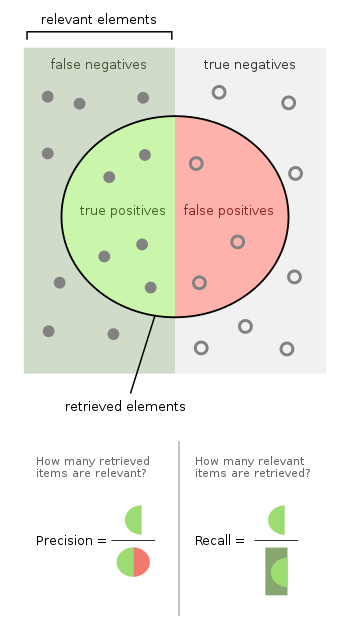

In [ ]:
# Use the predict() function on the testing data and compare to the actual value of y_test .
# Calculate the precision, recall, and F1 scores for this classifier.

y_pred = svc.predict(x_test)
testing_df['prediction'] = y_pred

precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f'Classifier Results on Test dataset using {len(y_test)} samples:')
print(f'Testing Precision (true positives/identified positives) is ' + str(100.0 * precision) + '%')
print(f'Testing Recall (true positives found/total number of true positives) is ' + str(100.0 * recall) + '%' )
print(f'Testing F1 Score (harmonic mean of precision and recall) ' + str(100.0 * f1) + '%' )

In [ ]:
# Get the results of applying the classifier to the testing set
def get_pred_result(pred, actual):
    if pred == 1 and actual == 1:
        return "True Positive"
    if pred == 1 and actual == 0:
        return "False Positive"
    if pred == 0 and actual == 1:
        return "False Negative"
    if pred == 0 and actual == 0:
        return "True Negative"
    
testing_df['result'] = testing_df.apply(lambda x: get_pred_result(x.prediction, x.isobfuscated), axis=1)


In [ ]:
# Plot the results of the testing data
fig2 = px.scatter(testing_df, x='length', y='alphacount', color='result', hover_name='commandline', title="Results of Test Set Prediction")
fig2.show()

# Part II: Apply Model to an Uncontrolled Dataset

At this point, we have trained and tested our model.  We can now apply it to a fresh, uncontrolled dataset.  Generate a new set with the same search logic used before: 
    eventid:(800|1) userID:<yourIDformat> NOT commandline:*.ps1*
    
This version does not need to be categorized as obfuscated|non-obfuscated; we are going to let the model predict this for each entry in the dataset with the predict() function. The code will then scatterplot the results and output any commands found to be obfuscated.

In [ ]:
# Niiiiiiiiiiiice.

# Let's use this to find obfuscation in a new, uncontrolled set of Powershell commands.
# Apply the model to a new, uncontrolled dataset, and return items predicted to be obfuscated by the model.
file2 = input("Enter the location of a CSV file:")
path = os.path.dirname(file2)
newdf = pd.read_csv(file2, encoding="ANSI", header=0)

# Strip off leading/trailing whitespace
newdf['commandline'] = newdf['commandline'].str.strip()

# Create a "length" column, containing the string length of each command
newdf['length'] = newdf['commandline'].str.len()

newdf = newdf.dropna(axis=0)
print('Ingested ' + str(newdf.shape[0]) + ' lines of data')

In [ ]:
# Build features for this dataset

newdf['semicoloncount'] = newdf['commandline'].str.count('\;')
newdf['doublequotecount'] = newdf['commandline'].str.count('\"')
newdf['singlequotecount'] = newdf['commandline'].str.count('\'')
newdf['backtickcount'] = newdf['commandline'].str.count('\`')
newdf['plussigncount'] = newdf['commandline'].str.count('\+')
newdf['leftbracecount'] = newdf['commandline'].str.count('\{')
newdf['leftbracketcount'] = newdf['commandline'].str.count('\[')
newdf['leftparencount'] = newdf['commandline'].str.count('\(')
newdf['pipecount'] = newdf['commandline'].str.count('\|')
newdf['alphacount'] = newdf['commandline'].str.count('[a-zA-Z]')
newdf['camelswitchcount'] = newdf['commandline'].str.count('[a-z][A-Z]|[A-Z][a-z]')
newdf['dollarsigncount'] = newdf['commandline'].str.count('\$')
newdf['digitcount'] = newdf['commandline'].str.count('[0-9]')

X_new = newdf[['length', 'semicoloncount', 'doublequotecount', 'singlequotecount', 'backtickcount', 'plussigncount', 'leftbracecount','leftbracketcount', 'leftparencount', 'pipecount', 'alphacount', 'camelswitchcount', 'dollarsigncount', 'digitcount']]


In [ ]:
# Use the predict() function on your new uncontrolled data and collect the results.

y_new = svc.predict(X_new)
newdf['prediction'] = y_new

In [ ]:
# Scatterplot the results

newdf['prediction'] = newdf['prediction'].astype(str) #for categorical graphing purposes
fig3 = px.scatter(newdf, x='length', y='alphacount', color='prediction', hover_name='commandline', title='Classification of Obfuscated/Non-Obfuscated Commands')
fig3.show()
newdf['prediction'] = newdf['prediction'].astype(int) #flip it back after graphing

In [ ]:
# Find commands predicted to be obfuscated, export results to csv

obfuscatedcommands = newdf[newdf['prediction'] == 1]
originaldatasize = newdf.shape[0]
obfuscatedcount = obfuscatedcommands.shape[0]
obfuscatedpercentage = (obfuscatedcount/originaldatasize) * 100

print ("Obfuscated commands found: " + str(obfuscatedcount) + " of " + str(originaldatasize) + ", " + str(obfuscatedpercentage) + "%")
obfuscatedcommands[['commandline', 'length', 'alphacount']].to_csv(os.path.join(path, 'predictedobfuscated.csv'), encoding="ANSI", header=0)